# 지점별로 선형모델 생성하기

In [90]:
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import os
import pandas as pd

In [91]:
tf.__version__

'2.10.1'

## 1-1 입출력 데이터셋 준비

In [92]:
pwd

'd:\\연구\\RnD_new\\1DCNN'

### 예측 데이터 concat, label 설정

In [93]:
def concat_by_month(directory_path):
    """
    CSV 파일을 읽어와 월별로 데이터를 분류하고 병합
    모든 월의 데이터를 하나의 데이터프레임으로 return, 각 행은 월 정보를 포함

    :param directory_path: CSV 파일이 저장된 디렉토리 경로
    :return: 하나의 데이터프레임으로 병합된 월별 데이터
    """
    # 파일 목록을 읽어온다
    file_list = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

    # 월별 데이터를 저장할 딕셔너리 초기화
    monthly_data = {str(i): [] for i in range(1, 13)}

    # 파일명에서 날짜를 파싱하여 해당 월에 맞는 데이터 프레임 리스트에 추가
    for file_name in file_list:
        date_part = file_name.split('_')[4]  # '20220614' 형식의 문자열 추출
        month = date_part[4:6]  # 월 정보 추출
        
        if month[0] == '0':
            month = month[1]  # '01'과 같은 경우 '1'로 변환
        
        # 파일 읽기
        file_path = os.path.join(directory_path, file_name)
        df = pd.read_csv(file_path)
        df = df[:-1]
        df['Month'] = month  # 월 정보를 데이터프레임에 추가

        # 해당 월에 데이터프레임 추가
        monthly_data[month].append(df)
        
    # 모든 월별 데이터를 하나의 데이터프레임으로 병합
    month_order = ['6', '7', '8', '9', '10', '11', '12', '1', '2', '3', '4', '5']
    all_months_df = pd.concat([pd.concat(monthly_data[month], ignore_index=True) for month in month_order if monthly_data[month]], ignore_index=True)
    
    return all_months_df

In [94]:
month_df = concat_by_month('../south3')

In [95]:
month_df

,model_fct,model_u,model_v,Month
0,2022-06-01 00:00:00,-2.17227,2.33468,6
1,2022-06-01 01:00:00,-2.20096,2.60714,6
2,2022-06-01 02:00:00,-0.82373,1.76651,6
3,2022-06-01 03:00:00,-1.45177,1.71002,6
4,2022-06-01 04:00:00,-1.26527,-0.51782,6
...,...,...,...,...
26131,2023-05-31 19:00:00,-3.82630,-1.70959,5
26132,2023-05-31 20:00:00,-3.31416,-1.51797,5
26133,2023-05-31 21:00:00,-3.51577,-0.45597,5
26134,2023-05-31 22:00:00,-3.09054,0.48458,5


### 관측데이터 label 설정

In [96]:
def create_month_column(filename):
    """
    현재 디렉토리에서 지정된 파일을 읽어 'obs_time' 열을 파싱하여 월 정보를 추출하고
    새로운 'Month' 열을 데이터프레임에 추가한 후 반환합니다.

    :param filename: 읽을 파일의 이름
    :return: 'Month' 열이 추가된 데이터프레임
    """
    # 현재 디렉토리 경로 설정
    current_directory = os.getcwd()
    # 파일 경로 완성
    file_path = os.path.join(current_directory, filename)
    
    # 파일이 존재하는지 확인
    if os.path.exists(file_path):
        # 파일 읽기
        df = pd.read_csv(file_path)
        # 'obs_time' 열이 있는지 확인 후 처리
        if 'obs_time' in df.columns:
            # 'obs_time' 열에서 날짜를 파싱하여 월 정보 추출
            df['Month'] = pd.to_datetime(df['obs_time']).dt.month
            return df
        else:
            raise ValueError("The file does not contain an 'obs_time' column.")
    else:
        raise FileNotFoundError("The specified file does not exist in the current directory.")

# 사용 예:
# filename = 'your_data.csv'
# updated_data = create_month_column_from_obs_time(filename)
# print(updated_data.head())  # 'obs_time'과 'Month' 열을 포함하는 데이터프레임 출력


In [97]:
obs_df = create_month_column('../../RnD_Ensemble/south_obs_KG_0025.csv')

In [98]:
obs_df

,obs_time,obs_u,obs_v,Month
0,2022-06-01 00:00:00,0.249494,1.173777,6
1,2022-06-01 01:00:00,-0.165808,0.111839,6
2,2022-06-01 02:00:00,-0.682059,0.157466,6
3,2022-06-01 03:00:00,-0.678733,1.224468,6
4,2022-06-01 04:00:00,-0.777146,0.629320,6
...,...,...,...,...
8755,2023-05-31 19:00:00,NaN,NaN,5
8756,2023-05-31 20:00:00,NaN,NaN,5
8757,2023-05-31 21:00:00,NaN,NaN,5
8758,2023-05-31 22:00:00,NaN,NaN,5


### 입출력 데이터 프레임 생성

In [99]:
obs_df.columns

Index(['obs_time', 'obs_u', 'obs_v', 'Month'], dtype='object')

In [100]:
month_df.columns

Index(['model_fct', 'model_u', 'model_v', 'Month'], dtype='object')

In [101]:
def create_input_output_data(df_obs, df_pred, start_date, end_date):
    """
    파라미터:
    - df_obs (pd.DataFrame): 관측 데이터를 포함하는 데이터프레임
    - df_pred (pd.DataFrame): 예측 데이터를 포함하는 데이터프레임
    - start_date (str 또는 pd.Timestamp): 데이터 선택을 시작할 날짜 ('YYYY-MM-DD' 형식).
    - end_date (str 또는 pd.Timestamp): 데이터 선택을 종료할 날짜 ('YYYY-MM-DD' 형식).

    반환 값:
    - input_df (pd.DataFrame): 관측값과 예측값이 결합된 (96시간씩) 데이터 프레임
    - output_df (pd.DataFrame): 관측 데이터 (48시간씩) 출력 데이터 프레임
    """
    
    # 시간 열을 datetime 형식으로 변환
    df_obs['obs_time'] = pd.to_datetime(df_obs['obs_time'])
    df_pred['obs_time'] = pd.to_datetime(df_pred['model_fct']) # model_fct를 통일성을 위해 obs_time 이름으로 사용
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # input, ouput dataframes
    input_frames = []
    output_frames = []
    
    start_index = 0
    start_index2 = 0
    # 날짜별로 데이터 프레임 구성
    for single_date in pd.date_range(start_date, end_date):
        
        # 관측값은 전일 0h-23h만 선택

        # 시작 인덱스로부터 24개의 행을 슬라이싱
        obs_data_yesterday = df_obs.loc[start_index:start_index + 23, ['obs_time', 'obs_u', 'obs_v']].copy()
        obs_data_yesterday.rename(columns={'obs_u': 'u', 'obs_v': 'v'}, inplace=True)
        
        start_index += 24
        # 'type' 컬럼을 추가하고 'obs'로 설정 (데이터 확인용)
        obs_data_yesterday['type'] = 'obs'
        
        # 예측값은 당일에서 24~71h 후
        # single_date에 해당하는 인덱스를 찾기

        # 시작 인덱스로부터 72개의 행을 슬라이싱
        pred_data_range = df_pred.loc[start_index2:start_index2 + 71, ['obs_time', 'model_u', 'model_v']].copy()
        start_index2 += 72
        
        # 열 이름 변경 및 'type' 컬럼 추가 (데이터 확인용)
        pred_data_range.rename(columns={'model_u': 'u', 'model_v': 'v'}, inplace=True)
        pred_data_range['type'] = 'model'
        if not pred_data_range.empty and len(pred_data_range) >= 25:
            month_value = pred_data_range['obs_time'].iloc[24].month
            pred_data_range['month'] = int(month_value)
            obs_data_yesterday['month'] = int(month_value)
        elif not pred_data_range.empty:
            pred_data_range['month'] = pred_data_range['obs_time'].dt.month.iloc[0]
        else:
            continue  # 데이터가 없으면 이번 루프는 건너뛰기
        
        # input 데이터는 관측값과 예측값을 병합 (관측치 24시간 + 예측치 72시간)
        combined_input = pd.concat([obs_data_yesterday, pred_data_range])

        
        # output 데이터는 다음날 24h부터 내일 모레까지 71h의 관측값
        output_data = df_obs[
            (df_obs['obs_time'] >= single_date + pd.DateOffset(days=1)) & 
            (df_obs['obs_time'] < single_date + pd.DateOffset(days=3))
        ][['obs_time', 'obs_u', 'obs_v']].copy()
        output_data.rename(columns={'obs_u': 'u', 'obs_v': 'v'}, inplace=True)
        output_data['month'] = output_data['obs_time'].iloc[0].month

        
        input_frames.append(combined_input)
        output_frames.append(output_data)

    
    input_df = pd.concat(input_frames, ignore_index=True)
    output_df = pd.concat(output_frames, ignore_index=True)
    
    # 모든 데이터 프레임에서 'obs_time' 열 이름을 'time'으로 변경
    input_df.rename(columns={'obs_time': 'time'}, inplace=True)
    output_df.rename(columns={'obs_time': 'time'}, inplace=True)

    return input_df, output_df


In [102]:
# 입력 및 출력 데이터 생성
input_df, output_df = create_input_output_data(obs_df, month_df, '2022-06-01', '2023-05-31')

In [103]:
input_df[:96]

,time,u,v,type,month
0,2022-06-01 00:00:00,0.249494,1.173777,obs,6
1,2022-06-01 01:00:00,-0.165808,0.111839,obs,6
2,2022-06-01 02:00:00,-0.682059,0.157466,obs,6
3,2022-06-01 03:00:00,-0.678733,1.224468,obs,6
4,2022-06-01 04:00:00,-0.777146,0.629320,obs,6
...,...,...,...,...,...
91,2022-06-03 19:00:00,-6.485700,-2.870270,model,6
92,2022-06-03 20:00:00,-7.223740,-3.021450,model,6
93,2022-06-03 21:00:00,-6.869860,-3.205860,model,6
94,2022-06-03 22:00:00,-7.261990,-2.787200,model,6


In [104]:
# 출력 데이터는 관측치 48개씩
output_df[:48]

,time,u,v,month
0,2022-06-02 00:00:00,3.999391,-0.069810,6
1,2022-06-02 01:00:00,3.287443,0.287614,6
2,2022-06-02 02:00:00,4.108220,0.873229,6
3,2022-06-02 03:00:00,3.284148,0.879985,6
4,2022-06-02 04:00:00,2.735824,1.845337,6
5,2022-06-02 05:00:00,3.534600,1.648211,6
6,2022-06-02 06:00:00,3.464102,2.000000,6
7,2022-06-02 07:00:00,3.186298,2.580214,6
8,2022-06-02 08:00:00,3.419442,2.769010,6
9,2022-06-02 09:00:00,4.073041,3.069257,6


### 96(192), 48(96)개씩 데이터 잘라서 입출력 생성

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [106]:
# 시간, u,v, month 열만 사용
input = input_df[['time', 'u', 'v', 'month']]
output = output_df[['time', 'u', 'v', 'month']]

In [107]:
input[:26]

,time,u,v,month
0,2022-06-01 00:00:00,0.249494,1.173777,6
1,2022-06-01 01:00:00,-0.165808,0.111839,6
2,2022-06-01 02:00:00,-0.682059,0.157466,6
3,2022-06-01 03:00:00,-0.678733,1.224468,6
4,2022-06-01 04:00:00,-0.777146,0.629320,6
5,2022-06-01 05:00:00,-0.629320,0.777146,6
6,2022-06-01 06:00:00,-0.250512,1.782483,6
7,2022-06-01 07:00:00,0.483844,1.940591,6
8,2022-06-01 08:00:00,0.609226,1.587087,6
9,2022-06-01 09:00:00,NaN,NaN,6


In [108]:
input.to_csv('input.csv')

In [109]:
output

,time,u,v,month
0,2022-06-02 00:00:00,3.999391,-0.069810,6
1,2022-06-02 01:00:00,3.287443,0.287614,6
2,2022-06-02 02:00:00,4.108220,0.873229,6
3,2022-06-02 03:00:00,3.284148,0.879985,6
4,2022-06-02 04:00:00,2.735824,1.845337,6
...,...,...,...,...
17419,2023-05-31 19:00:00,NaN,NaN,5
17420,2023-05-31 20:00:00,NaN,NaN,5
17421,2023-05-31 21:00:00,NaN,NaN,5
17422,2023-05-31 22:00:00,NaN,NaN,5


In [110]:
# time열을 input, ouput 데이터프레임의 인덱스로 지정
columns = ['u', 'v', 'month']

input_feat = input_df[columns]
input_feat.index = input_df['time']

output_feat = output_df[columns]
output_feat.index = output_df['time']

In [111]:
input_feat[96*3+23:96*3+50]

,u,v,month
time,,,
2022-06-04 23:00:00,-6.29904,0.10995,6
2022-06-04 00:00:00,-7.22692,-3.73084,6
2022-06-04 01:00:00,-7.06593,-3.66937,6
2022-06-04 02:00:00,-6.22906,-3.95180,6
2022-06-04 03:00:00,-6.25298,-4.22260,6
2022-06-04 04:00:00,-6.62916,-4.37544,6
2022-06-04 05:00:00,-6.60844,-4.36879,6
2022-06-04 06:00:00,-6.67698,-3.98170,6
2022-06-04 07:00:00,-6.45223,-3.48829,6


In [112]:
output_feat

,u,v,month
time,,,
2022-06-02 00:00:00,3.999391,-0.069810,6
2022-06-02 01:00:00,3.287443,0.287614,6
2022-06-02 02:00:00,4.108220,0.873229,6
2022-06-02 03:00:00,3.284148,0.879985,6
2022-06-02 04:00:00,2.735824,1.845337,6
...,...,...,...
2023-05-31 19:00:00,NaN,NaN,5
2023-05-31 20:00:00,NaN,NaN,5
2023-05-31 21:00:00,NaN,NaN,5


In [113]:
# DataFrame을 numpy 배열로 변환
input_array = input_feat.values
output_array = output_feat.values

In [114]:
# 배열별로 결측치 세기
nan_count_in_input = np.sum(np.isnan(input_array))
nan_count_in_output = np.sum(np.isnan(output_array))

In [115]:
nan_count_in_input

868

In [116]:
nan_count_in_output

1774

In [117]:
input_array.shape

(34848, 3)

In [118]:
output_array.shape

(17424, 3)

In [119]:
len(input_array)

34848

In [120]:
len(output_array)

17424

In [121]:
input_array[94*3:94*4]

array([[-8.06379000e+00, -7.92737000e+00,  6.00000000e+00],
       [-7.80077000e+00, -7.79446000e+00,  6.00000000e+00],
       [-7.83106000e+00, -7.35919000e+00,  6.00000000e+00],
       [-6.44266000e+00, -7.45057000e+00,  6.00000000e+00],
       [-5.91664000e+00, -7.78948000e+00,  6.00000000e+00],
       [-5.67275000e+00, -8.38756000e+00,  6.00000000e+00],
       [-7.89239752e+00, -1.82210354e+00,  6.00000000e+00],
       [-7.89239752e+00, -1.82210354e+00,  6.00000000e+00],
       [-6.71040171e+00, -3.56798388e+00,  6.00000000e+00],
       [-6.52802608e+00, -5.28629128e+00,  6.00000000e+00],
       [-6.46535998e+00, -5.82143628e+00,  6.00000000e+00],
       [-7.09209678e+00, -5.54095328e+00,  6.00000000e+00],
       [-7.42731024e+00, -5.59687972e+00,  6.00000000e+00],
       [-7.62714567e+00, -5.14457471e+00,  6.00000000e+00],
       [-7.27461339e+00, -4.20000000e+00,  6.00000000e+00],
       [-7.84207558e+00, -3.01029078e+00,  6.00000000e+00],
       [-8.30696211e+00, -2.22584379e+00

In [122]:
output_array[:2]

array([[ 3.99939078, -0.06980963,  6.        ],
       [ 3.2874425 ,  0.28761395,  6.        ]])

### 샘플 생성 및 nan 제거

In [123]:
def simple_slice_data(input_data, output_data, input_window, output_window):
    """
    파라미터:
    - input_data (np.array): 모델 입력을 위한 원본 데이터 배열
    - output_data (np.array): 모델 출력(예측 대상)을 위한 원본 데이터 배열
    - input_window (int): 한 번에 입력으로 사용할 데이터 포인트의 수
    - output_window (int): 한 번에 출력으로 사용할 데이터 포인트의 수

    반환 값:
    - X (np.array): 입력 데이터 슬라이스의 배열.
    - y (np.array): 출력 데이터 슬라이스의 배열.
    """
    
    X = []
    y = []

    # 데이터셋의 최대 인덱스를 계산
    max_index = len(output_data) // 48
    print("max_index: {}".format(max_index))
    
    for i in range(max_index):
        
        # 입출력 데이터 슬라이스
        input_slice = input_data[i * input_window: (i + 1) * input_window]
        output_slice = output_data[i * output_window: (i + 1) * output_window]

        X.append(input_slice)
        y.append(output_slice)

    # 배열로 변환
    X = np.array(X)
    y = np.array(y)

    return X, y


In [124]:
# 입력은 96개씩 행이 한 샘플, 출력은 48개씩 행이 한 샘플 (하루치)
input_window = 96
output_window = 48
X, y = simple_slice_data(input_array, output_array, input_window, output_window)

print("X shape:", X.shape)  # (N, 96, 3)
print("y shape:", y.shape)  # (N, 48, 3)

max_index: 363
X shape: (363, 96, 3)
y shape: (363, 48, 3)


In [125]:
# 입출력에 있는 결측치 세기
X_nan = np.sum(np.isnan(X))
y_nan = np.sum(np.isnan(y))

In [126]:
X_nan

868

In [127]:
y_nan

1774

In [128]:
len(X)

363

In [129]:
len(y)

363

In [130]:
# 입력 데이터에서 결측치 위치 찾기
nan_indices_input = np.unique(np.where(np.isnan(X))[0])
nan_indices_input

array([  0,   6,   7,  17,  19,  30,  35,  40,  44,  45,  46,  52,  65,
        81,  82, 107, 111, 112, 121, 122, 123, 124, 135, 140, 141, 147,
       150, 166, 167, 178, 188, 200, 203, 207, 208, 224, 225, 226, 265,
       300, 318, 319, 320, 322, 332, 338, 339, 340, 349, 351], dtype=int64)

In [131]:
# 출력 데이터에서 결측치 위치 찾기
nan_indices_output = np.unique(np.where(np.isnan(y))[0])
nan_indices_output

array([  4,   5,   6,  15,  16,  17,  18,  28,  29,  33,  34,  38,  39,
        42,  43,  44,  45,  50,  51,  63,  64,  79,  80,  81, 105, 106,
       109, 110, 111, 119, 120, 121, 122, 123, 133, 134, 138, 139, 140,
       145, 146, 148, 149, 164, 165, 166, 176, 177, 186, 187, 198, 199,
       201, 202, 205, 206, 207, 222, 223, 224, 225, 263, 264, 298, 299,
       316, 317, 318, 319, 320, 321, 330, 331, 336, 337, 338, 339, 347,
       348, 349, 350, 361, 362], dtype=int64)

In [132]:
# 두 배열을 합쳐서 중복된 값 제거
common_nan_indices = np.unique(np.concatenate([nan_indices_input, nan_indices_output]))

In [133]:
nan_indices_input

array([  0,   6,   7,  17,  19,  30,  35,  40,  44,  45,  46,  52,  65,
        81,  82, 107, 111, 112, 121, 122, 123, 124, 135, 140, 141, 147,
       150, 166, 167, 178, 188, 200, 203, 207, 208, 224, 225, 226, 265,
       300, 318, 319, 320, 322, 332, 338, 339, 340, 349, 351], dtype=int64)

In [134]:
nan_indices_output

array([  4,   5,   6,  15,  16,  17,  18,  28,  29,  33,  34,  38,  39,
        42,  43,  44,  45,  50,  51,  63,  64,  79,  80,  81, 105, 106,
       109, 110, 111, 119, 120, 121, 122, 123, 133, 134, 138, 139, 140,
       145, 146, 148, 149, 164, 165, 166, 176, 177, 186, 187, 198, 199,
       201, 202, 205, 206, 207, 222, 223, 224, 225, 263, 264, 298, 299,
       316, 317, 318, 319, 320, 321, 330, 331, 336, 337, 338, 339, 347,
       348, 349, 350, 361, 362], dtype=int64)

In [135]:
# 두 배열을 합쳐서 중복된 값 제거
common_nan_indices = np.unique(np.concatenate([nan_indices_input, nan_indices_output]))

In [136]:
# input, output 샘플에서 통째로 날려야하는 n번째 샘플들
len(common_nan_indices)

113

In [137]:
common_nan_indices

array([  0,   4,   5,   6,   7,  15,  16,  17,  18,  19,  28,  29,  30,
        33,  34,  35,  38,  39,  40,  42,  43,  44,  45,  46,  50,  51,
        52,  63,  64,  65,  79,  80,  81,  82, 105, 106, 107, 109, 110,
       111, 112, 119, 120, 121, 122, 123, 124, 133, 134, 135, 138, 139,
       140, 141, 145, 146, 147, 148, 149, 150, 164, 165, 166, 167, 176,
       177, 178, 186, 187, 188, 198, 199, 200, 201, 202, 203, 205, 206,
       207, 208, 222, 223, 224, 225, 226, 263, 264, 265, 298, 299, 300,
       316, 317, 318, 319, 320, 321, 322, 330, 331, 332, 336, 337, 338,
       339, 340, 347, 348, 349, 350, 351, 361, 362], dtype=int64)

In [138]:
# input보다 큰 샘플 개수 삭제
valid_indices = common_nan_indices[common_nan_indices < len(X)]

In [139]:
len(valid_indices)

113

In [140]:
# input, ouput에서 common_nan_indices에 나열된 인덱스의 샘플들을 삭제
cleaned_X = np.delete(X, valid_indices, axis=0)
cleaned_y = np.delete(y, valid_indices, axis=0)

# 제거되고 남은 샘플 개수 확인
print(cleaned_X.shape)
print(cleaned_y.shape)

(250, 96, 3)
(250, 48, 3)


In [141]:
# 배열 전체에서 NaN 값 확인
nan_exists = np.isnan(cleaned_y).any()

In [142]:
nan_exists

False

In [143]:
print(cleaned_X.shape)

(250, 96, 3)


In [144]:
cleaned_X[0]

array([[ 3.99939078, -0.06980963,  6.        ],
       [ 3.2874425 ,  0.28761395,  6.        ],
       [ 4.10821992,  0.8732291 ,  6.        ],
       [ 3.28414781,  0.87998475,  6.        ],
       [ 2.73582399,  1.84533658,  6.        ],
       [ 3.53460037,  1.64821122,  6.        ],
       [ 3.46410162,  2.        ,  6.        ],
       [ 3.18629844,  2.5802136 ,  6.        ],
       [ 3.41944223,  2.76900972,  6.        ],
       [ 4.0730411 ,  3.06925662,  6.        ],
       [ 3.73141162,  2.33164476,  6.        ],
       [ 4.07960896,  1.64826901,  6.        ],
       [ 4.3571795 ,  0.61236164,  6.        ],
       [ 4.39900188,  1.34490984,  6.        ],
       [ 4.4432588 ,  1.19056761,  6.        ],
       [ 5.12109604,  2.72293506,  6.        ],
       [ 5.02294734,  2.9       ,  6.        ],
       [ 5.17770876,  3.76182561,  6.        ],
       [ 5.29856365,  2.35907253,  6.        ],
       [ 4.88640163,  1.77850475,  6.        ],
       [ 5.15482718,  2.18809432,  6.   

In [145]:
cleaned_y.shape

(250, 48, 3)

In [146]:
import numpy as np
import pandas as pd

# cleaned_X_reshaped와 cleaned_y_reshaped 배열이 주어졌다고 가정
# 예시 데이터 생성을 위한 코드는 생략합니다. 실제 데이터 사용을 가정

# 각 시간 단계를 별도의 행으로 변환하고, 열은 u, v, month로 설정
# cleaned_X_reshaped.reshape(-1, 3)는 모든 시간 단계를 행으로, 특성을 열로 펼칩니다.
df_X = pd.DataFrame(cleaned_X.reshape(-1, 3), columns=['u', 'v', 'month'])
df_y = pd.DataFrame(cleaned_y.reshape(-1, 3), columns=['u', 'v', 'month'])

# 'month' 열을 정수형으로 변환
df_X['month'] = df_X['month'].astype(int)
df_y['month'] = df_y['month'].astype(int)

# DataFrame을 CSV 파일로 저장
df_X.to_csv("X.csv", index=False)
df_y.to_csv("y.csv", index=False)

# 저장된 파일 확인 메시지
print("Data has been saved to cleaned_X_reshaped.csv and cleaned_y_reshaped.csv.")


Data has been saved to cleaned_X_reshaped.csv and cleaned_y_reshaped.csv.


## 월별인덱스 확인 및 정규화

In [147]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Reshape

In [148]:
# 월별로 인덱스를 분할할 리스트 초기화
monthly_indices = [[] for _ in range(12)]

total = 0
# 월별로 인덱스를 분할
for month in range(1, 13):
    indices = [i for i in range(cleaned_y.shape[0]) if int(cleaned_y[i, 0, 2]) == month]
    
    # 중복 제거 및 리스트로 변환
    total += len(indices)
    print("{0}월의 인덱스: {1}".format(month, indices))
    print("{0}월의 인덱스 개수: {1}".format(month,len(indices)))
    print('================================')
    monthly_indices[month-1].append(indices)

print("전체 index 개수: {}개".format(total))

# K-폴드 교차 검증 설정
kf = KFold(n_splits=12)

1월의 인덱스: [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158]
1월의 인덱스 개수: 26
2월의 인덱스: [159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183]
2월의 인덱스 개수: 25
3월의 인덱스: [184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211]
3월의 인덱스 개수: 28
4월의 인덱스: [212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231]
4월의 인덱스 개수: 20
5월의 인덱스: [232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249]
5월의 인덱스 개수: 18
6월의 인덱스: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
6월의 인덱스 개수: 18
7월의 인덱스: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
7월의 인덱스 개수: 15
8월의 인덱스: [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
8월의 인덱스 개수: 

In [149]:
cleaned_X.shape

(250, 96, 3)

In [150]:
cleaned_y.shape

(250, 48, 3)

## feature 4로 X 분리

In [151]:
# 각 24시간 구간을 4개의 feature로 나누기 위해 reshape
# (batch_size, total_time_steps, features) -> (batch_size, 4, time_steps_per_feature, original_features)
reshaped_X = cleaned_X.reshape((cleaned_X.shape[0], 4, 24, cleaned_X.shape[2]))

# 각 시간 구간별로 feature명을 지정하고 데이터프레임으로 변환 후 numpy 배열로 변환
numpy_arrays = []
for i in range(reshaped_X.shape[1]):  # 4개의 24시간 구간
    data = reshaped_X[:, i, :, :].reshape(-1, reshaped_X.shape[3])
    df = pd.DataFrame(data, columns=[f"feature_{j+1}" for j in range(reshaped_X.shape[3])])
    numpy_array = df.to_numpy()  # 데이터프레임을 numpy 배열로 변환
    numpy_arrays.append(numpy_array)
    print(f"Numpy array for time segment {i+1}:")
    print(numpy_array)
    print("\n")

# 각 시간 구간에 대한 numpy 배열
feature1, feature2, feature3, feature4 = numpy_arrays

# feature들을 24시간씩 잘라서 (sample_size, 24, 3) 형태로 변환
def reshape_features(feature):
    num_samples = feature.shape[0] // 24
    reshaped_feature = feature[:num_samples * 24].reshape(num_samples, 24, feature.shape[1])
    return reshaped_feature

feature1 = reshape_features(feature1)
feature2 = reshape_features(feature2)
feature3 = reshape_features(feature3)
feature4 = reshape_features(feature4)

Numpy array for time segment 1:
[[ 3.99939078 -0.06980963  6.        ]
 [ 3.2874425   0.28761395  6.        ]
 [ 4.10821992  0.8732291   6.        ]
 ...
 [ 1.48467696  6.43084243  5.        ]
 [ 1.63055998  6.08533271  5.        ]
 [ 2.00686052  5.22805039  5.        ]]


Numpy array for time segment 2:
[[ 3.43869  1.23156  6.     ]
 [ 3.32552  0.90594  6.     ]
 [ 3.17408  0.99565  6.     ]
 ...
 [-0.52637  7.52456  5.     ]
 [-0.93307  7.42741  5.     ]
 [-1.13584  7.48273  5.     ]]


Numpy array for time segment 3:
[[ 4.73782 -1.1076   6.     ]
 [ 3.75431 -1.6791   6.     ]
 [ 3.44985 -0.57597  6.     ]
 ...
 [ 4.05969  5.01327  5.     ]
 [ 4.04926  4.85134  5.     ]
 [ 4.06316  4.74879  5.     ]]


Numpy array for time segment 4:
[[-6.58134 -3.784    6.     ]
 [-6.62279 -3.66107  6.     ]
 [-6.59888 -3.62452  6.     ]
 ...
 [-6.54109 -5.08182  5.     ]
 [-7.24673 -4.59872  5.     ]
 [-7.75655 -5.47585  5.     ]]




In [152]:
# 마지막 차원의 크기를 2로 변경 (예시로 첫 번째와 두 번째 feature만 사용)
reshaped_X = reshaped_X[:, :, :, :2]
reshaped_X.shape

(250, 4, 24, 2)

In [153]:
reshaped_X

array([[[[ 3.99939078, -0.06980963],
         [ 3.2874425 ,  0.28761395],
         [ 4.10821992,  0.8732291 ],
         ...,
         [ 5.04059954,  1.63779007],
         [ 4.77441332,  1.10226017],
         [ 4.91669659,  1.6929544 ]],

        [[ 3.43869   ,  1.23156   ],
         [ 3.32552   ,  0.90594   ],
         [ 3.17408   ,  0.99565   ],
         ...,
         [ 5.48861   ,  1.92101   ],
         [ 6.14056   ,  0.43412   ],
         [ 5.76438   , -0.68728   ]],

        [[ 4.73782   , -1.1076    ],
         [ 3.75431   , -1.6791    ],
         [ 3.44985   , -0.57597   ],
         ...,
         [-7.05158   , -3.26567   ],
         [-6.72481   , -3.0065    ],
         [-6.65626   , -3.39857   ]],

        [[-6.58134   , -3.784     ],
         [-6.62279   , -3.66107   ],
         [-6.59888   , -3.62452   ],
         ...,
         [-6.52077   ,  1.2598    ],
         [-6.9145    ,  1.9775    ],
         [-5.59783   ,  5.45467   ]]],


       [[[ 5.01124845,  1.72551122],
         

In [154]:
X = np.concatenate((feature1, feature2, feature3, feature4), axis=2)

In [155]:
X.shape

(250, 24, 12)

In [156]:
X = np.delete(X, [2,5,8,11], axis=2)

In [157]:
import pandas as pd

# 샘플 하나 선택
sample = X[0]  # 첫 번째 샘플 선택, shape=(24, 8)

# DataFrame으로 변환
df = pd.DataFrame(sample)


In [158]:
df

,0,1,2,3,4,5,6,7
0,3.999391,-0.069810,3.43869,1.23156,4.73782,-1.10760,-6.58134,-3.78400
1,3.287443,0.287614,3.32552,0.90594,3.75431,-1.67910,-6.62279,-3.66107
2,4.108220,0.873229,3.17408,0.99565,3.44985,-0.57597,-6.59888,-3.62452
3,3.284148,0.879985,2.64806,1.60702,3.21075,0.90095,-6.46020,-3.44841
4,2.735824,1.845337,2.88557,2.71015,1.63107,0.23476,-6.58134,-3.43346
5,3.534600,1.648211,3.65070,3.41455,0.31600,-0.42479,-6.67380,-3.50822
6,3.464102,2.000000,4.03167,3.37468,-1.13456,-0.41150,-6.17806,-3.40854
7,3.186298,2.580214,3.66504,3.63385,-1.00066,0.97571,-6.28326,-3.13276
8,3.419442,2.769010,4.22295,4.71870,-0.21959,2.04894,-6.43948,-2.98823
9,4.073041,3.069257,4.95620,4.01263,0.73204,0.59859,-6.41556,-2.60114


In [159]:
X

array([[[ 3.99939078, -0.06980963,  3.43869   , ..., -1.1076    ,
         -6.58134   , -3.784     ],
        [ 3.2874425 ,  0.28761395,  3.32552   , ..., -1.6791    ,
         -6.62279   , -3.66107   ],
        [ 4.10821992,  0.8732291 ,  3.17408   , ..., -0.57597   ,
         -6.59888   , -3.62452   ],
        ...,
        [ 5.04059954,  1.63779007,  5.48861   , ..., -3.26567   ,
         -6.52077   ,  1.2598    ],
        [ 4.77441332,  1.10226017,  6.14056   , ..., -3.0065    ,
         -6.9145    ,  1.9775    ],
        [ 4.91669659,  1.6929544 ,  5.76438   , ..., -3.39857   ,
         -5.59783   ,  5.45467   ]],

       [[ 5.01124845,  1.72551122,  3.88661   , ..., -3.83717   ,
         -4.54737   ,  8.42679   ],
        [ 4.2693012 ,  1.06445634,  3.51361   , ..., -3.61621   ,
         -5.79549   ,  7.12265   ],
        [ 4.18976901,  0.29297719,  2.64009   , ..., -3.26899   ,
         -6.23703   ,  6.01121   ],
        ...,
        [-7.5481398 , -3.20399525, -6.60207   , ...,  

In [160]:
cleaned_y.shape

(250, 48, 3)

In [161]:
# 3번째 열을 제거
y_processed = cleaned_y[:, :, :2]

In [162]:
y_processed.shape

(250, 48, 2)

In [163]:
X.shape

(250, 24, 8)

# 2. 모델 성능 측정

## 시간대별 (24~71h) 데이터 정리 및 저장

In [164]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, PReLU, Dense, AveragePooling1D, MaxPooling1D, Dropout, BatchNormalization, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
import itertools
from tensorflow.keras.initializers import glorot_normal
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU ,Lambda, Activation, Bidirectional,GlobalMaxPooling1D
from keras.utils import plot_model
from tensorflow.keras.models import Model


In [165]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager, rc

plt.rc('font', family='NanumGothic')

def plot_loss_and_rmse_graphs(history, test_loss, month):
    """
    주어진 history 객체를 사용하여 훈련 및 검증 손실(MSE) 그래프와 RMSE 그래프를 로그 스케일로 그립니다.
    """

    plt.figure(figsize=(12, 6))

    # 훈련 및 검증 손실 추이 그래프 (MSE)
    plt.subplot(121)
    plt.plot(history.history['loss'], label='Training Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.axhline(y=test_loss, color='r', linestyle='-', label='Test Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend(loc='upper right')
    plt.title(f'Model Loss (MSE) - Month {month+1}')
    plt.grid(True)
    plt.tight_layout()
    
    # RMSE 값 계산
    train_rmse = [round(np.sqrt(x), 4) for x in history.history['loss']]
    val_rmse = [round(np.sqrt(x), 4) for x in history.history['val_loss']]
    test_rmse = round(np.sqrt(test_loss), 4)
    
    # 훈련 및 검증 RMSE 그래프
    plt.subplot(122)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.axhline(y=test_rmse, color='r', linestyle='-', label='Test RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(loc='upper right')
    plt.title(f'Model RMSE - Month {month+1}')
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()


In [187]:
def build_regression_model(input_steps, features, output_steps, output_features, CONV_WIDTH, STRIDE):
    inputs = Input(shape=(input_steps, features))
    x = Conv1D(filters=32, kernel_size=CONV_WIDTH, strides=STRIDE, activation='elu')(inputs)
    x = Dropout(0.4)(x)
    
    residual = Flatten()(x)
    dense_out = Dense(units=output_steps * output_features, activation='linear')(residual)
    outputs = Reshape((output_steps, output_features))(dense_out)
    
    # Functional API로 모델 생성
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    return model

In [188]:
from IPython.display import Image
from sklearn.preprocessing import RobustScaler

def calculate_and_store_results(cleaned_X, cleaned_y, unique_monthly_indices):
    # 결과를 저장할 딕셔너리 초기화
    results_dict = {i: {'predictions': [], 'true_values': []} for i in range(48)}
    all_results = []  # 모든 결과를 담기 위한 리스트
    all_loss = []
    all_val_loss = []
    
    # 모든 폴드에 대한 손실 값을 저장할 리스트
    fold_train_losses = []
    fold_val_losses = []
    fold_test_losses = []
    fold_rmse_values = []
    
    # 12-fold 검증
    for month in range(12):
        
        # 인덱스 설정
        test_indices = unique_monthly_indices[month]
        train_indices = []
        
        for month_idx in range(12):
            if month_idx != month:
                train_indices.extend(unique_monthly_indices[month_idx])

        # 이중 리스트를 하나의 리스트로 풀어내기
        train_flatten_indices = list(itertools.chain(*train_indices))
        test_flatten_indices = list(itertools.chain(*test_indices))
    
        print("test_indices{}".format(test_flatten_indices))
        
        X_test = cleaned_X[test_flatten_indices, :, :]
        y_test = cleaned_y[test_flatten_indices, :, :]
        X_train = cleaned_X[train_flatten_indices, :, :]
        y_train = cleaned_y[train_flatten_indices, :, :]

        # 예측 실행 전 데이터 존재 여부 확인 (월 전체가 결측치인 경우)
        if X_test.size == 0:
            print("No data available for predictions.")
            continue
            
        # u,v를 이어붙여서 모양 재생성
        #y_test_reshaped = y_test.reshape(y_test.shape[0], -1)
        #y_train_reshaped = y_train.reshape(y_train.shape[0], -1)

        # train, validation data split
        X_train_reshaped, X_val_reshaped, y_train_reshaped, y_val_reshaped = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, shuffle=False)
        
        # 2차원 배열로 변환
        X_test_reshaped = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
        X_val_reshaped = X_val_reshaped.reshape(X_val_reshaped.shape[0] * X_val_reshaped.shape[1], X_val_reshaped.shape[2])
        X_train_reshaped = X_train_reshaped.reshape(X_train_reshaped.shape[0] * X_train_reshaped.shape[1], X_train_reshaped.shape[2])
        
        # 스케일러 초기화 및 훈련 데이터에 대해 fit
        scaler = MaxAbsScaler()
        X_train_reshaped = scaler.fit_transform(X_train_reshaped)
        X_val_reshaped = scaler.transform(X_val_reshaped)
        X_test_reshaped = scaler.transform(X_test_reshaped)
        
        # 다시 3차원 배열로 변환
        X_train_reshaped = X_train_reshaped.reshape(-1, 24, 8)
        X_val_reshaped = X_val_reshaped.reshape(-1, 24, 8)
        X_test_reshaped = X_test_reshaped.reshape(-1, 24, 8)
        
        print("print test, train, validation shape")
        print(X_test_reshaped.shape)
        print(y_test.shape)
        print(X_train_reshaped.shape)
        print(y_train_reshaped.shape)
        print(X_val_reshaped.shape)
        print(y_val_reshaped.shape)

        # 입력 데이터의 형태
        input_steps = 24
        features = 8
        output_steps = 48  # 예측하고자 하는 출력의 time_steps
        output_features = 2  # 예측하고자 하는 출력의 feature 수
        CONV_WIDTH = 2
        STRIDE = 1
        model = build_regression_model(input_steps, features, output_steps, output_features, CONV_WIDTH, STRIDE)
        
        # 조기 종료 및 학습률 감소 콜백 설정
        early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
        
        # 모델 학습 및 손실 추적
        history = model.fit(X_train_reshaped, y_train_reshaped, epochs=400, batch_size=128,
                            validation_data=(X_val_reshaped, y_val_reshaped), 
                            callbacks=early_stopping)
        
        y_pred_reshaped = model.predict(X_test_reshaped)
        
        
        # 손실 추이 저장
        fold_train_loss = history.history['loss']
        fold_val_loss = history.history['val_loss']
        fold_test_loss, fold_test_mse = model.evaluate(X_test_reshaped, y_test, verbose=0)

        print(f'fold_test_mse: {fold_test_mse}')

        # RMSE 계산 및 저장
        fold_rmse = np.sqrt(fold_test_loss)
        fold_rmse_values.append(fold_rmse)

        print(f'Month {month + 1}: MSE = {fold_test_loss}, RMSE = {fold_rmse}')
        
        # 모든 폴드의 손실 추이 저장
        fold_train_losses.append(fold_train_loss)
        fold_val_losses.append(fold_val_loss)
        fold_test_losses.append(fold_test_loss)
            
        all_loss.extend(history.history['loss'])
        all_val_loss.extend(history.history['val_loss'])
    
        print('------------------------------------')
        print("y_pred, y_test shape")
        print(y_pred_reshaped.shape)
        print(y_test.shape)
        print('------------------------------------')

        # 각 폴드의 결과를 48개 그룹으로 나누어 저장
        for i in range(0,48):
            if i == 1:
                print(y_pred_reshaped)
                print(y_pred_reshaped[:, i, :])
                print(y_test[:, i, :])
            results_dict[i]['predictions'].extend(y_pred_reshaped[:, i, :])
            results_dict[i]['true_values'].extend(y_test[:, i, :])
            
            ''' if i ==0: # 0번째 행이 잘 추출되는지 확인 완료
                print(results_dict[i]['predictions'])
                print(results_dict[i]['true_values']) '''
        
        # 각 폴드에 대한 손실 추이 그래프 그리기
        plot_loss_and_rmse_graphs(history, fold_test_loss, month)
    
    fold_average = np.mean(fold_rmse_values)
    print(f'fold average: {fold_average}')
    print(len(results_dict[1]['predictions']))
    print(len(results_dict[1]['true_values']))
    
    model.summary()
    
    # 모델 구조를 시각적으로 저장
    plot_model(model, to_file='combined_model_structure.png', show_shapes=True, show_layer_names=True)

    # 모델 구조를 화면에 출력 (Jupyter Notebook에서)
    Image('combined_model_structure.png')

    return results_dict, fold_rmse_values

In [189]:
import matplotlib.font_manager as fm

# 글리프 8722를 포함하는 폰트를 설정
font_path = fm.findfont(fm.FontProperties(family='DejaVu Sans'))
plt.rcParams['font.sans-serif'] = [font_path]
plt.rcParams['axes.unicode_minus'] = False

def plot_groupwise_scatter(results_dict):
    # 전체 데이터 수집을 위한 리스트
    all_predictions = []
    all_true_values = []

    for group, data in results_dict.items():
        predictions = np.array(data['predictions']).flatten()
        true_values = np.array(data['true_values']).flatten()

        plt.figure(figsize=(4, 4))
        plt.scatter(true_values, predictions, alpha=0.5, label=f'Group {group}', c='blue')
        plt.scatter(true_values, true_values, alpha=0.5, label='True Values', c='red')
        plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--', lw=2)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.legend()
        plt.grid(True)
        plt.title(f'Predictions vs True Values (Group {group})')
        plt.tight_layout()
        plt.show()

        all_predictions.extend(predictions)
        all_true_values.extend(true_values)

    # 전체 데이터에 대한 산점도
    all_predictions = np.array(all_predictions).flatten()
    all_true_values = np.array(all_true_values).flatten()

    plt.figure(figsize=(8, 8))
    plt.scatter(all_true_values, all_predictions, alpha=0.5, label='Predictions', c='blue')
    plt.scatter(all_true_values, all_true_values, alpha=0.5, label='True Values', c='red')
    plt.plot([all_true_values.min(), all_true_values.max()], [all_true_values.min(), all_true_values.max()], 'k--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend()
    plt.grid(True)
    plt.title('Predictions vs True Values (All Groups)')
    plt.tight_layout()
    plt.show()

test_indices[133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158]
print test, train, validation shape
(26, 24, 8)
(26, 48, 2)
(179, 24, 8)
(179, 48, 2)
(45, 24, 8)
(45, 48, 2)
Epoch 1/400
2/2 [==============================] - 0s 87ms/step - loss: 28.6439 - mse: 28.6439 - val_loss: 26.0189 - val_mse: 26.0189
Epoch 2/400
2/2 [==============================] - 0s 25ms/step - loss: 28.4297 - mse: 28.4297 - val_loss: 25.8326 - val_mse: 25.8326
Epoch 3/400
2/2 [==============================] - 0s 24ms/step - loss: 28.0854 - mse: 28.0854 - val_loss: 25.5761 - val_mse: 25.5761
Epoch 4/400
2/2 [==============================] - 0s 26ms/step - loss: 27.5824 - mse: 27.5824 - val_loss: 25.2390 - val_mse: 25.2390
Epoch 5/400
2/2 [==============================] - 0s 25ms/step - loss: 27.0022 - mse: 27.0022 - val_loss: 24.7949 - val_mse: 24.7949
Epoch 6/400
2/2 [==============================] - 0s 25ms/step - loss: 26.18

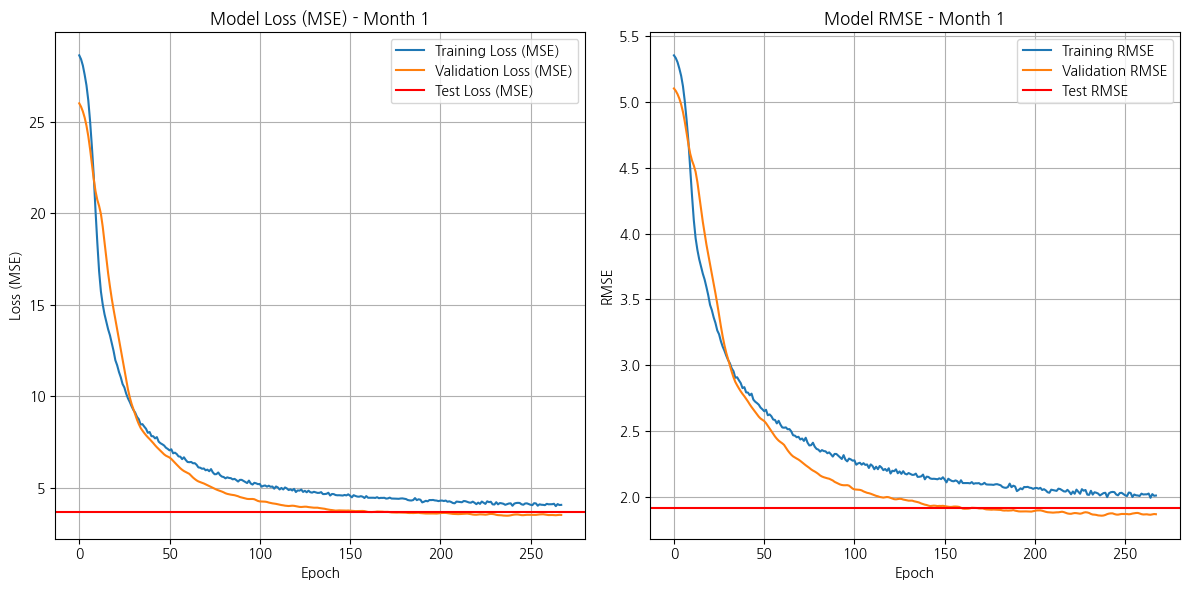

test_indices[159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183]
print test, train, validation shape
(25, 24, 8)
(25, 48, 2)
(180, 24, 8)
(180, 48, 2)
(45, 24, 8)
(45, 48, 2)
Epoch 1/400
2/2 [==============================] - 0s 82ms/step - loss: 29.7674 - mse: 29.7674 - val_loss: 26.1486 - val_mse: 26.1486
Epoch 2/400
2/2 [==============================] - 0s 21ms/step - loss: 29.6160 - mse: 29.6160 - val_loss: 25.9375 - val_mse: 25.9375
Epoch 3/400
2/2 [==============================] - 0s 21ms/step - loss: 29.3498 - mse: 29.3498 - val_loss: 25.6592 - val_mse: 25.6592
Epoch 4/400
2/2 [==============================] - 0s 21ms/step - loss: 29.0453 - mse: 29.0453 - val_loss: 25.3176 - val_mse: 25.3176
Epoch 5/400
2/2 [==============================] - 0s 20ms/step - loss: 28.6070 - mse: 28.6070 - val_loss: 24.8991 - val_mse: 24.8991
Epoch 6/400
2/2 [==============================] - 0s 21ms/step - loss: 28.0782 - 

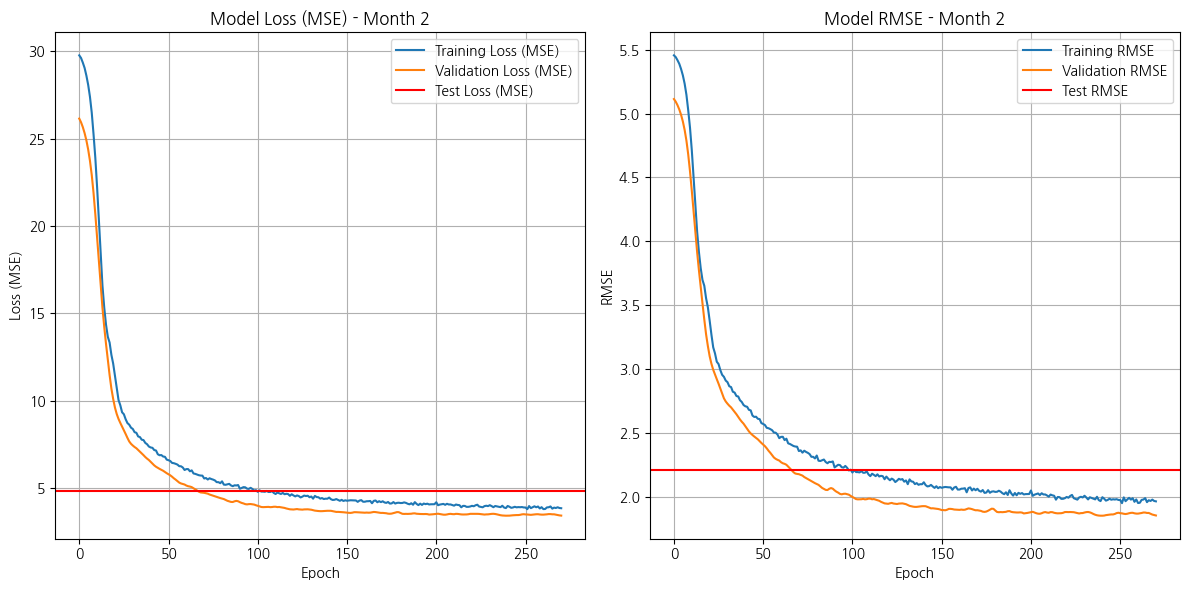

test_indices[184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211]
print test, train, validation shape
(28, 24, 8)
(28, 48, 2)
(177, 24, 8)
(177, 48, 2)
(45, 24, 8)
(45, 48, 2)
Epoch 1/400
2/2 [==============================] - 0s 83ms/step - loss: 30.3610 - mse: 30.3610 - val_loss: 26.2928 - val_mse: 26.2928
Epoch 2/400
2/2 [==============================] - 0s 22ms/step - loss: 30.1364 - mse: 30.1364 - val_loss: 26.0503 - val_mse: 26.0503
Epoch 3/400
2/2 [==============================] - 0s 23ms/step - loss: 29.8100 - mse: 29.8100 - val_loss: 25.7378 - val_mse: 25.7378
Epoch 4/400
2/2 [==============================] - 0s 24ms/step - loss: 29.3884 - mse: 29.3884 - val_loss: 25.3454 - val_mse: 25.3454
Epoch 5/400
2/2 [==============================] - 0s 23ms/step - loss: 28.8686 - mse: 28.8686 - val_loss: 24.8489 - val_mse: 24.8489
Epoch 6/400
2/2 [==============================] - 0s 24ms/step - l

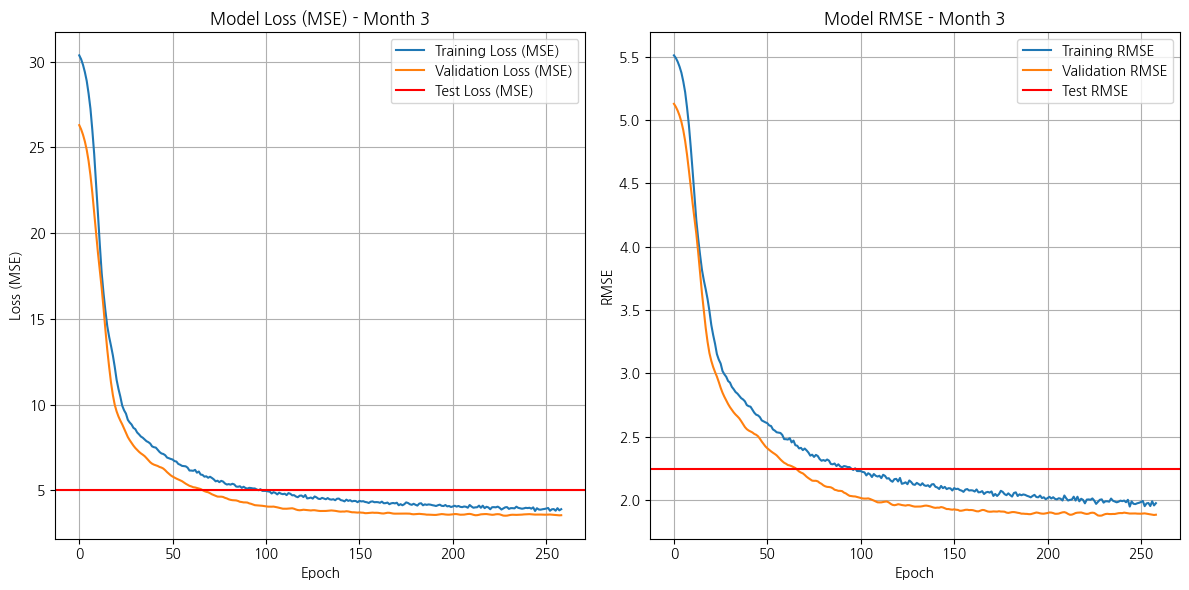

test_indices[212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231]
print test, train, validation shape
(20, 24, 8)
(20, 48, 2)
(184, 24, 8)
(184, 48, 2)
(46, 24, 8)
(46, 48, 2)
Epoch 1/400
2/2 [==============================] - 0s 90ms/step - loss: 27.9120 - mse: 27.9120 - val_loss: 26.4944 - val_mse: 26.4944
Epoch 2/400
2/2 [==============================] - 0s 26ms/step - loss: 27.7349 - mse: 27.7349 - val_loss: 26.2987 - val_mse: 26.2987
Epoch 3/400
2/2 [==============================] - 0s 23ms/step - loss: 27.5230 - mse: 27.5230 - val_loss: 26.0384 - val_mse: 26.0384
Epoch 4/400
2/2 [==============================] - 0s 26ms/step - loss: 27.2191 - mse: 27.2191 - val_loss: 25.7134 - val_mse: 25.7134
Epoch 5/400
2/2 [==============================] - 0s 25ms/step - loss: 26.8019 - mse: 26.8019 - val_loss: 25.3133 - val_mse: 25.3133
Epoch 6/400
2/2 [==============================] - 0s 25ms/step - loss: 26.3476 - mse: 26.3476 - val_loss: 

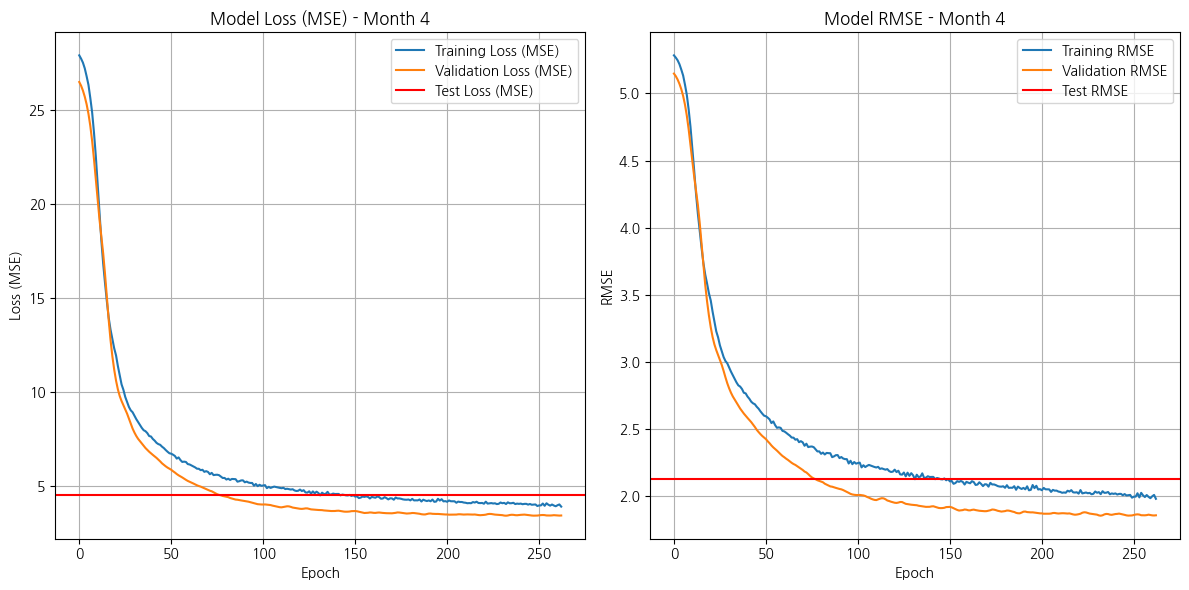

test_indices[232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249]
print test, train, validation shape
(18, 24, 8)
(18, 48, 2)
(185, 24, 8)
(185, 48, 2)
(47, 24, 8)
(47, 48, 2)
Epoch 1/400
2/2 [==============================] - 0s 87ms/step - loss: 31.0194 - mse: 31.0194 - val_loss: 26.7933 - val_mse: 26.7933
Epoch 2/400
2/2 [==============================] - 0s 28ms/step - loss: 30.7684 - mse: 30.7684 - val_loss: 26.5199 - val_mse: 26.5199
Epoch 3/400
2/2 [==============================] - 0s 25ms/step - loss: 30.3758 - mse: 30.3758 - val_loss: 26.1784 - val_mse: 26.1784
Epoch 4/400
2/2 [==============================] - 0s 24ms/step - loss: 29.8324 - mse: 29.8324 - val_loss: 25.7707 - val_mse: 25.7707
Epoch 5/400
2/2 [==============================] - 0s 28ms/step - loss: 29.2784 - mse: 29.2784 - val_loss: 25.2789 - val_mse: 25.2789
Epoch 6/400
2/2 [==============================] - 0s 26ms/step - loss: 28.4717 - mse: 28.4717 - val_loss: 24.6806 - 

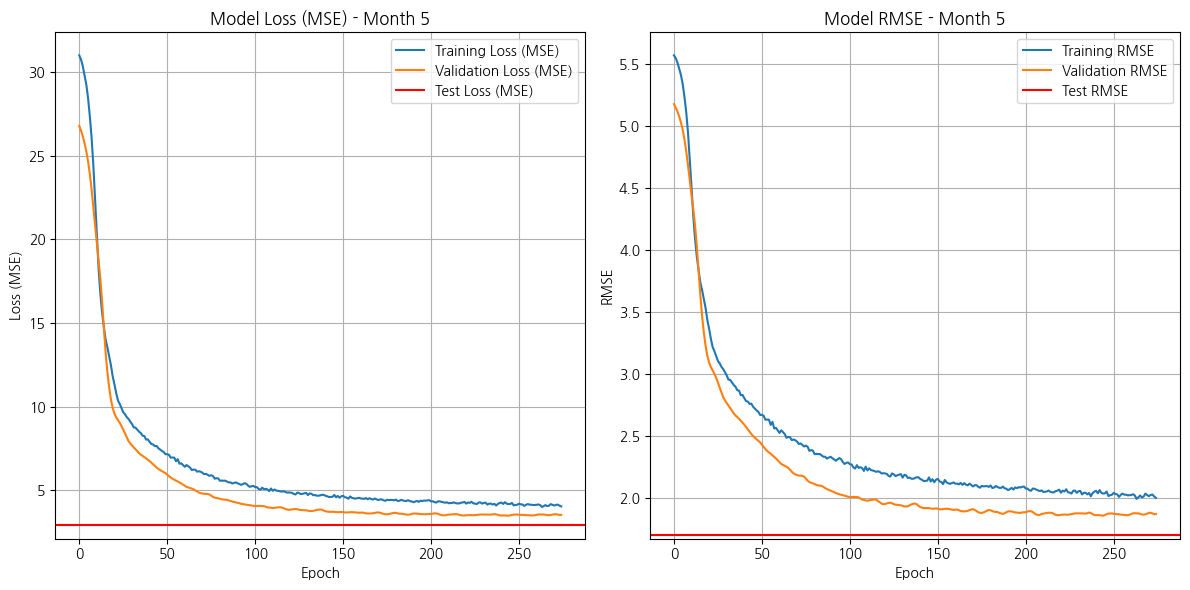

test_indices[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
print test, train, validation shape
(18, 24, 8)
(18, 48, 2)
(185, 24, 8)
(185, 48, 2)
(47, 24, 8)
(47, 48, 2)
Epoch 1/400
2/2 [==============================] - 0s 83ms/step - loss: 28.7571 - mse: 28.7571 - val_loss: 26.6620 - val_mse: 26.6620
Epoch 2/400
2/2 [==============================] - 0s 23ms/step - loss: 28.6210 - mse: 28.6210 - val_loss: 26.4820 - val_mse: 26.4820
Epoch 3/400
2/2 [==============================] - 0s 31ms/step - loss: 28.4090 - mse: 28.4090 - val_loss: 26.2413 - val_mse: 26.2413
Epoch 4/400
2/2 [==============================] - 0s 24ms/step - loss: 28.0779 - mse: 28.0779 - val_loss: 25.9356 - val_mse: 25.9356
Epoch 5/400
2/2 [==============================] - 0s 24ms/step - loss: 27.7066 - mse: 27.7066 - val_loss: 25.5470 - val_mse: 25.5470
Epoch 6/400
2/2 [==============================] - 0s 25ms/step - loss: 27.2005 - mse: 27.2005 - val_loss: 25.0467 - val_mse: 25.0467
Epoch 7/400

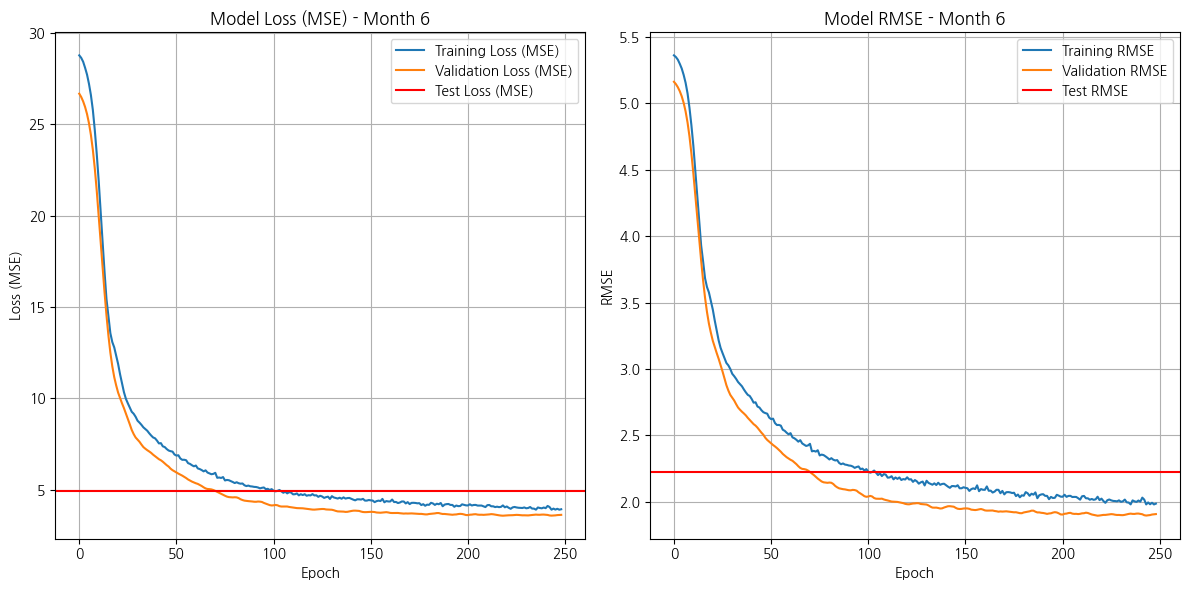

test_indices[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
print test, train, validation shape
(15, 24, 8)
(15, 48, 2)
(188, 24, 8)
(188, 48, 2)
(47, 24, 8)
(47, 48, 2)
Epoch 1/400
2/2 [==============================] - 0s 92ms/step - loss: 29.7831 - mse: 29.7831 - val_loss: 26.6667 - val_mse: 26.6667
Epoch 2/400
2/2 [==============================] - 0s 34ms/step - loss: 29.6427 - mse: 29.6427 - val_loss: 26.4493 - val_mse: 26.4493
Epoch 3/400
2/2 [==============================] - 0s 32ms/step - loss: 29.3553 - mse: 29.3553 - val_loss: 26.1587 - val_mse: 26.1587
Epoch 4/400
2/2 [==============================] - 0s 26ms/step - loss: 29.0053 - mse: 29.0053 - val_loss: 25.7874 - val_mse: 25.7874
Epoch 5/400
2/2 [==============================] - 0s 26ms/step - loss: 28.5587 - mse: 28.5587 - val_loss: 25.3193 - val_mse: 25.3193
Epoch 6/400
2/2 [==============================] - 0s 30ms/step - loss: 27.9685 - mse: 27.9685 - val_loss: 24.7274 - val_mse: 24.7274
Epoch 7/400
2

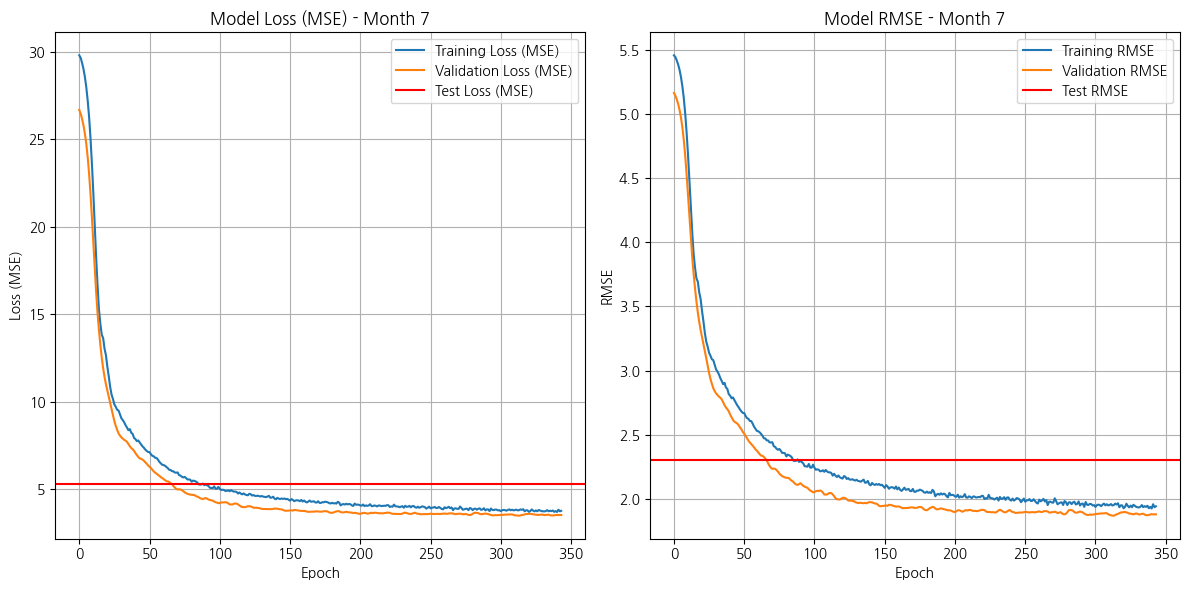

test_indices[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
print test, train, validation shape
(24, 24, 8)
(24, 48, 2)
(180, 24, 8)
(180, 48, 2)
(46, 24, 8)
(46, 48, 2)
Epoch 1/400
2/2 [==============================] - 0s 82ms/step - loss: 30.2156 - mse: 30.2156 - val_loss: 26.5109 - val_mse: 26.5109
Epoch 2/400
2/2 [==============================] - 0s 23ms/step - loss: 30.0698 - mse: 30.0698 - val_loss: 26.3484 - val_mse: 26.3484
Epoch 3/400
2/2 [==============================] - 0s 21ms/step - loss: 29.8228 - mse: 29.8228 - val_loss: 26.1313 - val_mse: 26.1313
Epoch 4/400
2/2 [==============================] - 0s 21ms/step - loss: 29.4812 - mse: 29.4812 - val_loss: 25.8540 - val_mse: 25.8540
Epoch 5/400
2/2 [==============================] - 0s 22ms/step - loss: 29.0472 - mse: 29.0472 - val_loss: 25.4941 - val_mse: 25.4941
Epoch 6/400
2/2 [==============================] - 0s 22ms/step - loss: 28.5249 - mse: 28.5249 - val_loss: 25.0

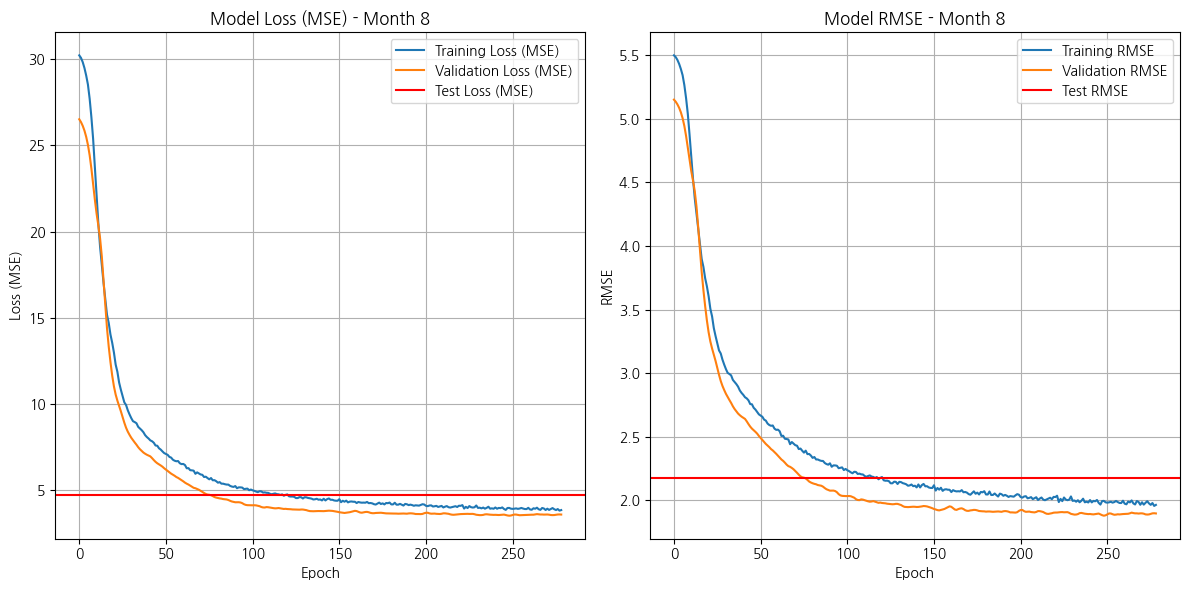

test_indices[57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
print test, train, validation shape
(21, 24, 8)
(21, 48, 2)
(183, 24, 8)
(183, 48, 2)
(46, 24, 8)
(46, 48, 2)
Epoch 1/400
2/2 [==============================] - 0s 94ms/step - loss: 27.0163 - mse: 27.0163 - val_loss: 26.4950 - val_mse: 26.4950
Epoch 2/400
2/2 [==============================] - 0s 27ms/step - loss: 26.7545 - mse: 26.7545 - val_loss: 26.0836 - val_mse: 26.0836
Epoch 3/400
2/2 [==============================] - 0s 24ms/step - loss: 26.2208 - mse: 26.2208 - val_loss: 25.5437 - val_mse: 25.5437
Epoch 4/400
2/2 [==============================] - 0s 30ms/step - loss: 25.5364 - mse: 25.5364 - val_loss: 24.8581 - val_mse: 24.8581
Epoch 5/400
2/2 [==============================] - 0s 30ms/step - loss: 24.7348 - mse: 24.7348 - val_loss: 23.9901 - val_mse: 23.9901
Epoch 6/400
2/2 [==============================] - 0s 26ms/step - loss: 23.6814 - mse: 23.6814 - val_loss: 22.8689 - val_ms

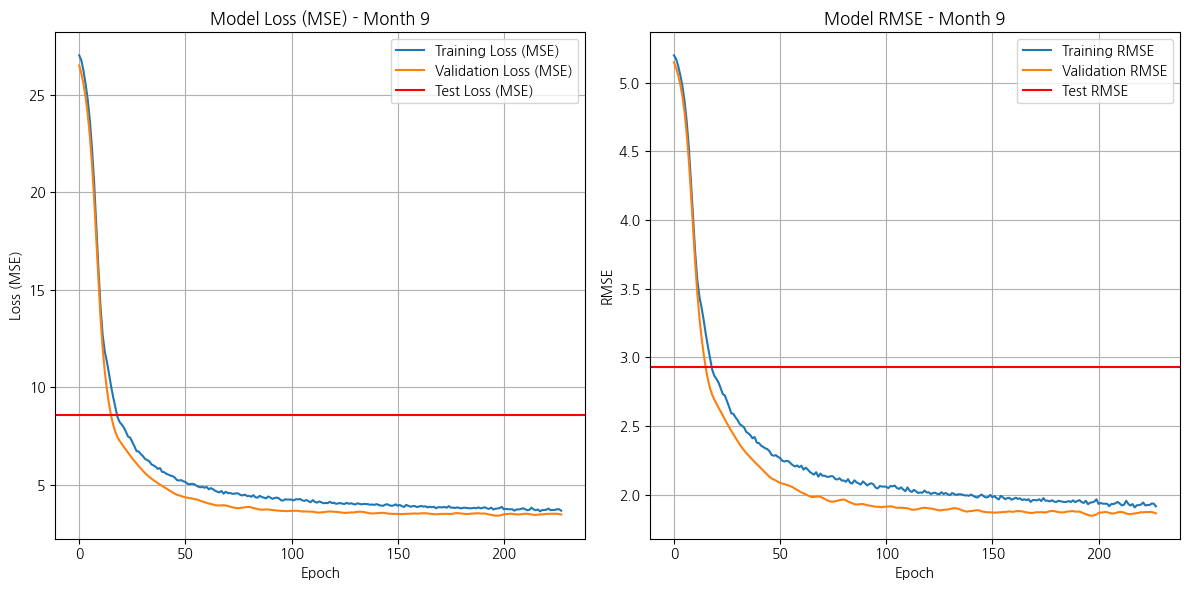

test_indices[78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]
print test, train, validation shape
(14, 24, 8)
(14, 48, 2)
(188, 24, 8)
(188, 48, 2)
(48, 24, 8)
(48, 48, 2)
Epoch 1/400
2/2 [==============================] - 0s 85ms/step - loss: 28.2598 - mse: 28.2598 - val_loss: 26.4551 - val_mse: 26.4551
Epoch 2/400
2/2 [==============================] - 0s 25ms/step - loss: 28.0747 - mse: 28.0747 - val_loss: 26.2088 - val_mse: 26.2088
Epoch 3/400
2/2 [==============================] - 0s 26ms/step - loss: 27.8060 - mse: 27.8060 - val_loss: 25.8796 - val_mse: 25.8796
Epoch 4/400
2/2 [==============================] - 0s 30ms/step - loss: 27.3863 - mse: 27.3863 - val_loss: 25.4576 - val_mse: 25.4576
Epoch 5/400
2/2 [==============================] - 0s 25ms/step - loss: 26.9284 - mse: 26.9284 - val_loss: 24.9272 - val_mse: 24.9272
Epoch 6/400
2/2 [==============================] - 0s 30ms/step - loss: 26.3292 - mse: 26.3292 - val_loss: 24.2713 - val_mse: 24.2713
Epoch 7/400
2/2 [

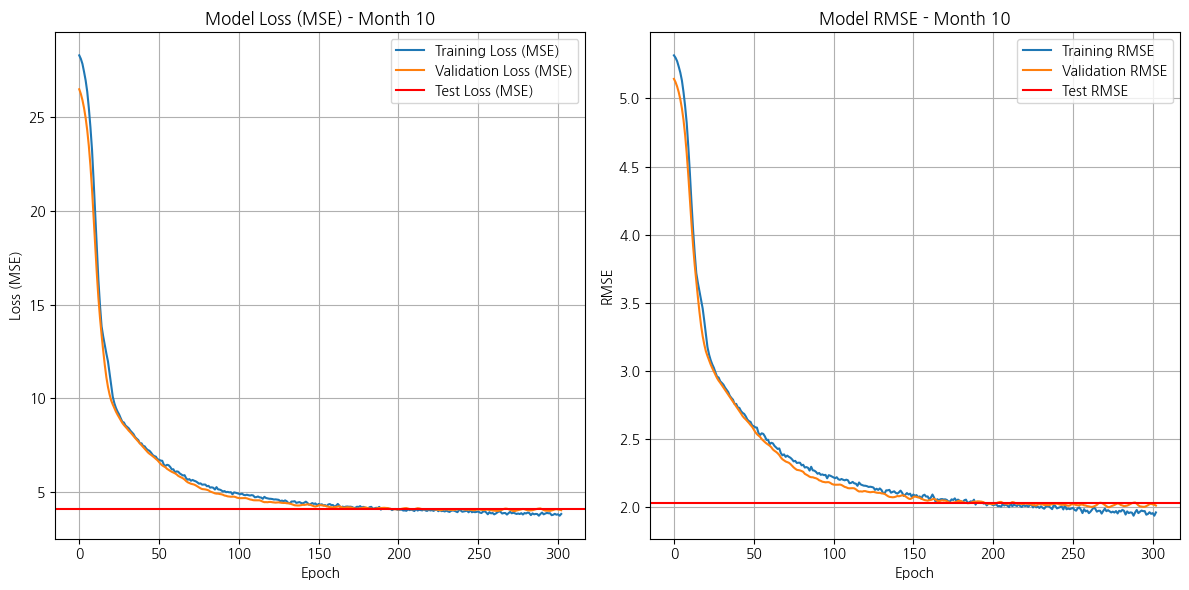

test_indices[92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]
print test, train, validation shape
(23, 24, 8)
(23, 48, 2)
(181, 24, 8)
(181, 48, 2)
(46, 24, 8)
(46, 48, 2)
Epoch 1/400
2/2 [==============================] - 0s 79ms/step - loss: 26.9896 - mse: 26.9896 - val_loss: 39.3830 - val_mse: 39.3830
Epoch 2/400
2/2 [==============================] - 0s 22ms/step - loss: 26.8199 - mse: 26.8199 - val_loss: 39.0294 - val_mse: 39.0294
Epoch 3/400
2/2 [==============================] - 0s 21ms/step - loss: 26.5912 - mse: 26.5912 - val_loss: 38.5652 - val_mse: 38.5652
Epoch 4/400
2/2 [==============================] - 0s 21ms/step - loss: 26.3143 - mse: 26.3143 - val_loss: 37.9938 - val_mse: 37.9938
Epoch 5/400
2/2 [==============================] - 0s 23ms/step - loss: 25.9395 - mse: 25.9395 - val_loss: 37.3009 - val_mse: 37.3009
Epoch 6/400
2/2 [==============================] - 0s 22ms/step - loss: 25.5157 - mse: 25.5157 - val

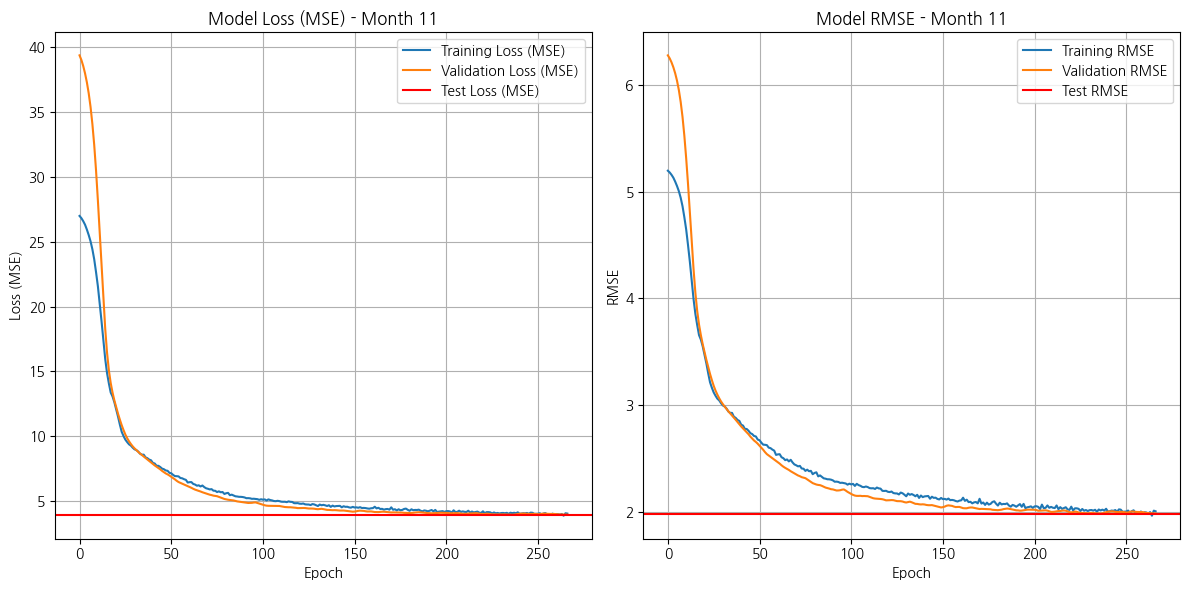

test_indices[115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
print test, train, validation shape
(18, 24, 8)
(18, 48, 2)
(185, 24, 8)
(185, 48, 2)
(47, 24, 8)
(47, 48, 2)
Epoch 1/400
2/2 [==============================] - 0s 88ms/step - loss: 27.3645 - mse: 27.3645 - val_loss: 32.0326 - val_mse: 32.0326
Epoch 2/400
2/2 [==============================] - 0s 22ms/step - loss: 27.2470 - mse: 27.2470 - val_loss: 31.7804 - val_mse: 31.7804
Epoch 3/400
2/2 [==============================] - 0s 22ms/step - loss: 26.9810 - mse: 26.9810 - val_loss: 31.4385 - val_mse: 31.4385
Epoch 4/400
2/2 [==============================] - 0s 22ms/step - loss: 26.6208 - mse: 26.6208 - val_loss: 30.9952 - val_mse: 30.9952
Epoch 5/400
2/2 [==============================] - 0s 22ms/step - loss: 26.2103 - mse: 26.2103 - val_loss: 30.4167 - val_mse: 30.4167
Epoch 6/400
2/2 [==============================] - 0s 23ms/step - loss: 25.7038 - mse: 25.7038 - val_loss: 29.6725 - 

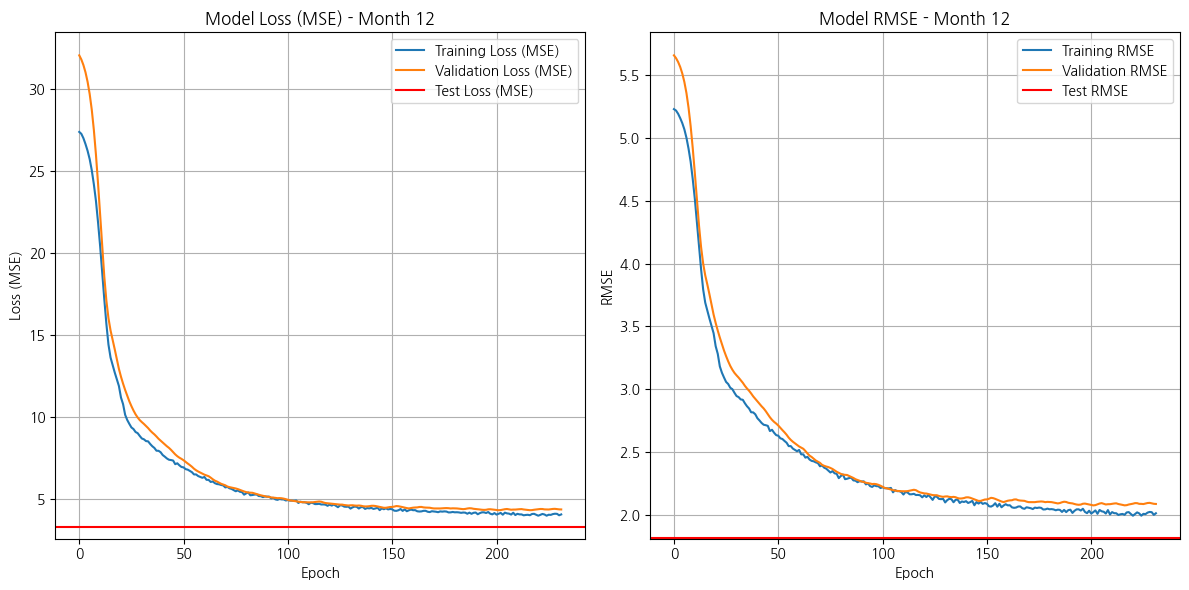

fold average: 2.1374234254659856
250
250
Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 24, 8)]           0         
                                                                 
 conv1d_36 (Conv1D)          (None, 23, 32)            544       
                                                                 
 dropout_36 (Dropout)        (None, 23, 32)            0         
                                                                 
 flatten_36 (Flatten)        (None, 736)               0         
                                                                 
 dense_36 (Dense)            (None, 96)                70752     
                                                                 
 reshape_36 (Reshape)        (None, 48, 2)             0         
                                                                 
Total params: 71,

In [190]:
import numpy as np
from sklearn.metrics import mean_squared_error

# RMSE 계산 함수
def calculate_groupwise_rmse(results):
    groupwise_rmse = {}

    for group_key, values in results.items():
            
        predictions = np.vstack(values['predictions'])
        true_values = np.vstack(values['true_values'])
        if group_key == 0:
            print(predictions)
            print(true_values)
            print(len(predictions))
            print(len(true_values))
        print("pred_length: {}".format(len(predictions)))
        print("true_length: {}".format(len(true_values)))
        
        # MSE 및 RMSE 계산
        mse = mean_squared_error(true_values, predictions, multioutput='uniform_average')
        rmse = np.sqrt(mse)
        
        # 소수점 4자리까지 반올림
        groupwise_rmse[group_key] = round(rmse, 4)

    return groupwise_rmse

# 결과 딕셔너리에서 모든 그룹의 RMSE 계산
results, rmse_values = calculate_and_store_results(X, y_processed, monthly_indices)
groupwise_rmse = calculate_groupwise_rmse(results)

In [191]:
# 결과 출력
for group_key, rmse in groupwise_rmse.items():
    print(f"RMSE for {group_key}: {rmse:.4f}")

RMSE for 0: 1.7459
RMSE for 1: 1.8041
RMSE for 2: 1.7626
RMSE for 3: 1.7529
RMSE for 4: 1.7231
RMSE for 5: 1.7492
RMSE for 6: 1.7033
RMSE for 7: 1.8902
RMSE for 8: 1.8505
RMSE for 9: 1.8915
RMSE for 10: 2.0244
RMSE for 11: 2.0799
RMSE for 12: 2.0478
RMSE for 13: 1.9800
RMSE for 14: 2.0362
RMSE for 15: 1.9910
RMSE for 16: 2.0513
RMSE for 17: 2.1173
RMSE for 18: 2.2088
RMSE for 19: 2.4912
RMSE for 20: 2.4939
RMSE for 21: 2.2440
RMSE for 22: 2.0746
RMSE for 23: 2.0246
RMSE for 24: 2.0502
RMSE for 25: 2.1285
RMSE for 26: 2.0709
RMSE for 27: 2.0532
RMSE for 28: 2.0577
RMSE for 29: 2.0607
RMSE for 30: 2.0556
RMSE for 31: 2.1824
RMSE for 32: 2.2515
RMSE for 33: 2.3312
RMSE for 34: 2.3590
RMSE for 35: 2.3899
RMSE for 36: 2.3417
RMSE for 37: 2.2206
RMSE for 38: 2.3393
RMSE for 39: 2.3501
RMSE for 40: 2.2786
RMSE for 41: 2.2917
RMSE for 42: 2.4448
RMSE for 43: 2.7247
RMSE for 44: 2.7247
RMSE for 45: 2.5820
RMSE for 46: 2.5067
RMSE for 47: 2.5475


In [192]:
df = pd.DataFrame(list(groupwise_rmse.values()), columns=['RMSE'])

In [193]:
df = df.transpose()

In [194]:
df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
RMSE,1.7459,1.8041,1.7626,1.7529,1.7231,1.7492,1.7033,1.8902,1.8505,1.8915,...,2.3393,2.3501,2.2786,2.2917,2.4448,2.7247,2.7247,2.582,2.5067,2.5475


In [195]:
df.iloc[0].mean()

2.14753125

In [196]:
df.iloc[0, :24].mean()

1.989095833333333

In [176]:
#df.to_excel('./rmse_s3_robust.xlsx')